In [14]:
import numpy as np
import os
import matplotlib.pyplot as plt
from adjustText import adjust_text

In [5]:
path = '../data'
def get_ficheiros(actor='',emocao='',orderby='actor',path='data'):
    actores = {i for i in os.listdir(path) if i.split('-')[-1].split('.')[0] == actor}
    emocoes = {i for i in os.listdir(path) if i.split('-')[2] == emocao}
    if (len(actores) == 0) ^ (len(emocoes) == 0):
        nome_ficheiros = list(actores.union(emocoes))
    else:
        nome_ficheiros = list(actores.intersection(emocoes))
        
    if len(nome_ficheiros) == 0:
        if orderby == 'actor':
            nome_ficheiros = sorted(os.listdir(path), key=lambda i: int(i.split('-')[-1].split('.')[0]))
        else:
            nome_ficheiros = sorted(os.listdir(path), key=lambda i: int(i.split('-')[2]))

    return nome_ficheiros

def get_maximo_frames(actor='',emocao='',path='data'):
    nome_ficheiros = get_ficheiros(actor=actor,emocao=emocao,path=path)
    nr_de_frames_maximo = 0
    i_max = 0
    for i,nome in enumerate(nome_ficheiros):
        with open(f'{path}/{nome}', 'r') as ficheiro:
            nr_de_frames = sum(1 for _ in ficheiro) - 1
        i_max,nr_de_frames_maximo = (i,nr_de_frames) if nr_de_frames_maximo < nr_de_frames else (i_max,nr_de_frames_maximo)
    return nr_de_frames_maximo,i_max

def get_dados_estruturados(actor='',emocao='',dimensao='3d',orderby='actor',e_column=False,path='data'):
    nr_de_landmarks = 68 
    nr_de_coordenadas = 2 
    nome_ficheiros = get_ficheiros(actor=actor,emocao=emocao,orderby=orderby,path=path)
    nr_de_videos = len(nome_ficheiros)
    nr_de_frames_maximo,i_max = get_maximo_frames(actor=actor,emocao=emocao,path=path)
    
    if dimensao == '3d' and e_column:
        dados_estruturados = np.full((nr_de_videos, nr_de_landmarks*nr_de_coordenadas + 1, nr_de_frames_maximo),np.nan)
        for i,nome in enumerate(nome_ficheiros):
            emo = nome.split('-')[2]
            with open(f'{path}/{nome}', 'r') as ficheiro:
                for j,frame in enumerate(ficheiro):
                    frame = frame.split(',')
                    if j == 0:
                        index = [i for i,_ in enumerate(frame) if _.startswith('x_') or _.startswith('y_')]
                    else:
                        frame = np.array(frame)[index]
                        frame = np.concatenate((frame,np.array([emo])),axis=0)
                        dados_estruturados[i,:,j-1] = frame
        return i_max,dados_estruturados
    
    elif dimensao == '3d':
        dados_estruturados = np.full((nr_de_videos, nr_de_landmarks*nr_de_coordenadas, nr_de_frames_maximo),np.nan)
        for i,nome in enumerate(nome_ficheiros):
            with open(f'{path}/{nome}', 'r') as ficheiro:
                for j,frame in enumerate(ficheiro):
                    frame = frame.split(',')
                    if j == 0:
                        index = [i for i,_ in enumerate(frame) if _.startswith('x_') or _.startswith('y_')]
                    else:
                        frame = np.array(frame)[index].astype('float')
                        dados_estruturados[i,:,j-1] = frame
        return i_max,dados_estruturados
    else:
        dados_estruturados = []
        for i,nome in enumerate(nome_ficheiros):
            actor = nome.split('-')[-1].split('.')[0]
            emocao = nome.split('-')[2]
            with open(f'{path}/{nome}', 'r') as ficheiro:
                for j,frame in enumerate(ficheiro):
                    frame = frame.split(',')
                    frame.extend([actor,emocao])
                    if j == 0:
                        index = [i for i,_ in enumerate(frame) if _.startswith('x_') or _.startswith('y_')]
                        index.extend([-2,-1])
                    else:
                        frame = np.array(frame)[index].astype('float')
                
                        dados_estruturados.append(frame)
        return np.array(dados_estruturados)

In [8]:
dados = get_dados_estruturados(dimensao='2d',orderby='emocao',path=path)
dados

array([[490.2, 488.8, 489.9, ..., 447.2,   1. ,   1. ],
       [490.2, 488.8, 489.9, ..., 446.5,   1. ,   1. ],
       [490.4, 488.8, 490.2, ..., 446.4,   1. ,   1. ],
       ...,
       [470.2, 474.4, 482.7, ..., 520.2,  24. ,   8. ],
       [466. , 470.5, 479.1, ..., 522.8,  24. ,   8. ],
       [461.1, 466.3, 475.8, ..., 526.2,  24. ,   8. ]])

In [9]:
def normalize_dados(dados):
    x = dados[:68]
    y = dados[68:]
    x_ref = (x[27] + x[8])/2
    x_max = 1280
    y_ref = (y[27] + y[8])/2
    y_max = 720
    x = (x-x_ref)/x_max
    y = (y-y_ref)/y_max
    return np.concatenate((x,y), axis=0)

dados_normalizados = normalize_dados(dados[:,:-2])
dados_normalizados = np.concatenate((dados_normalizados,dados[:,-2:]),1)
dados_normalizados

In [20]:
dados_normalizados.shape

(299854, 138)

In [28]:
frames = get_frames(dados_normalizados,path)

In [27]:
def get_frames(dados_normalizados,path):    
    frames = []
    for i,frame in enumerate(dados_normalizados):
        x = frame[:68]
        y = -frame[68:]
        if i == 0:
            xmin = min(x)
            xmax = max(x)
            ymin = min(y)
            ymax = max(y)
        else:
            xmin = min(x) if min(x) < xmin else xmin
            xmax = max(x) if max(x) > xmax else xmax
            ymin = min(y) if min(y) < ymin else ymin
            ymax = max(y) if max(y) > ymax else ymax
        frames.append(list(zip(x,y)))
    return frames,xmin,xmax,ymin,ymax

def plot_frames(actor='12',emocao='01',video_id='max',path='data'):
    frames,xmin,xmax,ymin,ymax = get_frames(actor=actor,emocao=emocao,video_id=video_id,path=path)
    fig, ax = plt.subplots()
    fig.set_facecolor('xkcd:midnight')
    ax.grid(False)
    ax.axis('off')
    cmapp = plt.get_cmap('Blues')
    for i,frame in enumerate(frames):
        for p in frame:
                x = p[0]
                y = p[1]
                ax.scatter(x, y, alpha=i/len(frames), facecolors='none', linewidth=3, edgecolors=cmapp(i/len(frames)), s=(12 * (len(frames)/(i+0.01)) ))
    # plt.savefig('presentation/2.5.png', dpi=300)
    plt.show()

KeyboardInterrupt: 

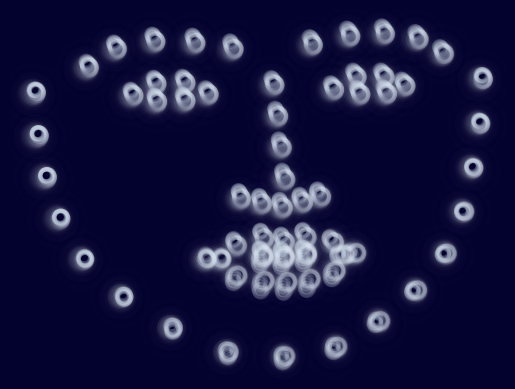

In [18]:
plot_frames(actor='12',emocao='01',video_id='max',path=path)